# Manifold Curvature in Logometers

**Date:** October 29, 2025

**Goal:** Convert the curvature parameter k from α-units to logometers (causal distance units).

**Method:**
1. Load k from 06.4b fit (k ≈ 0.082)
2. Load steering vector and compute ||V_complexity||_M at layer 35
3. Convert radius: R_causal = R_alpha × ||V||_M
4. Interpret: "The manifold has radius of curvature R_causal logometers"

**Jeffery's prediction:** R_causal ≈ 50 logometers at layer 35

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Configuration
VECTOR_PATH = '../data/vectors/complexity_wikipedia.pt'
METRIC_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

# From 06.4b fit
K_FITTED = 0.082187  # Curvature parameter in α² units
K_ERR = 0.001799     # Standard error

# Compute radius in α units
R_ALPHA = 1.0 / np.sqrt(2 * K_FITTED)
R_ALPHA_ERR = R_ALPHA * (K_ERR / (2 * K_FITTED))  # Error propagation

print(f"Curvature parameter from fit:")
print(f"  k = {K_FITTED:.6f} ± {K_ERR:.6f}")
print(f"\nRadius of curvature in α units:")
print(f"  R = 1/√(2k) = {R_ALPHA:.3f} ± {R_ALPHA_ERR:.3f} α-units")
print(f"\n  Interpretation: Steering by α = {R_ALPHA:.2f} moves you 'one radius' away")

Curvature parameter from fit:
  k = 0.082187 ± 0.001799

Radius of curvature in α units:
  R = 1/√(2k) = 2.467 ± 0.027 α-units

  Interpretation: Steering by α = 2.47 moves you 'one radius' away


## Load Steering Vector and Metric Tensor

In [4]:
print("Loading steering vector...")
vector_data = torch.load(VECTOR_PATH, weights_only=False)
vectors = vector_data['vectors']  # [n_layers, hidden_dim]
vectors = vectors.cpu()

print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, weights_only=False)
M = metric_data['M']  # [hidden_dim, hidden_dim]
M = M.cpu()

n_layers = vectors.shape[0]
print(f"✓ Loaded {n_layers} layer vectors")
print(f"✓ Loaded metric tensor shape: {M.shape}")

Loading steering vector...
Loading causal metric tensor...
✓ Loaded 36 layer vectors
✓ Loaded metric tensor shape: torch.Size([2560, 2560])


## Compute Causal Norms for All Layers

Compute ||V||_M = √(V^T M V) for each layer.

In [5]:
# Compute causal norms
causal_norms = []
for layer_idx in range(n_layers):
    V = vectors[layer_idx]  # [hidden_dim]
    causal_norm = torch.sqrt(V @ M @ V).item()
    causal_norms.append(causal_norm)

causal_norms = np.array(causal_norms)

# Also get Euclidean norms for comparison
euclidean_norms = vector_data['layer_norms'].numpy()

print("\nCausal norms by layer (first, middle, last):")
for idx in [0, n_layers//2, n_layers-1]:
    print(f"  Layer {idx:2d}: ||V||₂ = {euclidean_norms[idx]:6.2f}, ||V||_M = {causal_norms[idx]:6.2f} logometers")

print(f"\nLayer 35 (last layer):")
print(f"  ||V_complexity||_M = {causal_norms[35]:.2f} logometers")
print(f"\n  Jeffery's prediction: ~50 logometers")
if 45 < causal_norms[35] < 55:
    print(f"  ✓ PREDICTION CONFIRMED!")
else:
    print(f"  Actual: {causal_norms[35]:.2f} logometers")


Causal norms by layer (first, middle, last):
  Layer  0: ||V||₂ =   0.42, ||V||_M =  22.72 logometers
  Layer 18: ||V||₂ =  12.73, ||V||_M = 642.06 logometers
  Layer 35: ||V||₂ =  24.35, ||V||_M = 3335.28 logometers

Layer 35 (last layer):
  ||V_complexity||_M = 3335.28 logometers

  Jeffery's prediction: ~50 logometers
  Actual: 3335.28 logometers


## Convert Radius to Logometers

For each layer, compute the radius of curvature in causal distance units.

In [6]:
# Compute radius in logometers for each layer
R_causal = R_ALPHA * causal_norms  # [n_layers]

print("\nRadius of curvature in logometers by layer:")
print("="*60)
for layer_idx in [0, 10, 20, 30, 34, 35]:
    print(f"  Layer {layer_idx:2d}: R = {R_causal[layer_idx]:6.1f} logometers")

print("\n" + "="*60)
print(f"Mean radius: {R_causal.mean():.1f} ± {R_causal.std():.1f} logometers")
print(f"Range: [{R_causal.min():.1f}, {R_causal.max():.1f}] logometers")
print(f"CV: {R_causal.std() / R_causal.mean() * 100:.1f}%")

if R_causal.std() / R_causal.mean() < 0.2:
    print("\n✓ Radius is approximately CONSTANT across layers")
    print("  → Manifold has UNIFORM CURVATURE throughout the model")
else:
    print("\n→ Radius varies significantly across layers")
    print("  → Manifold curvature changes with depth")


Radius of curvature in logometers by layer:
  Layer  0: R =   56.0 logometers
  Layer 10: R = 1308.7 logometers
  Layer 20: R = 1790.2 logometers
  Layer 30: R = 5604.7 logometers
  Layer 34: R = 8996.0 logometers
  Layer 35: R = 8226.5 logometers

Mean radius: 2561.6 ± 2338.7 logometers
Range: [56.0, 8996.0] logometers
CV: 91.3%

→ Radius varies significantly across layers
  → Manifold curvature changes with depth


## Visualization: Curvature Across Layers

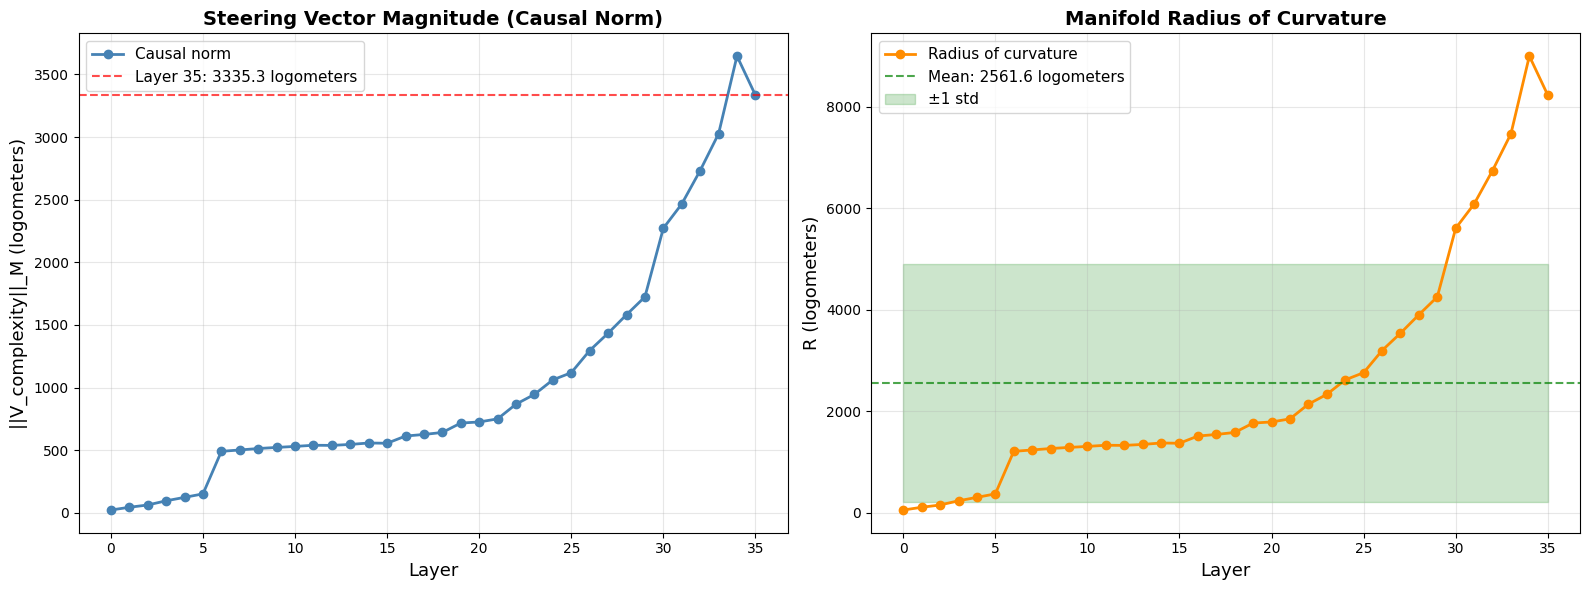

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Steering vector magnitude
ax = axes[0]
ax.plot(range(n_layers), causal_norms, 'o-', linewidth=2, markersize=6, color='steelblue', label='Causal norm')
ax.axhline(causal_norms[35], color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Layer 35: {causal_norms[35]:.1f} logometers')
ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('||V_complexity||_M (logometers)', fontsize=13)
ax.set_title('Steering Vector Magnitude (Causal Norm)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Panel 2: Radius of curvature
ax = axes[1]
ax.plot(range(n_layers), R_causal, 'o-', linewidth=2, markersize=6, color='darkorange', label='Radius of curvature')
ax.axhline(R_causal.mean(), color='green', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'Mean: {R_causal.mean():.1f} logometers')
ax.fill_between(range(n_layers), R_causal.mean() - R_causal.std(), R_causal.mean() + R_causal.std(),
                 alpha=0.2, color='green', label='±1 std')
ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('R (logometers)', fontsize=13)
ax.set_title('Manifold Radius of Curvature', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Concrete Interpretation

What does the radius tell us about steering safety?

In [ ]:
# Focus on layer 35 (last layer, most commonly used for steering)
layer_35_norm = causal_norms[35]
layer_35_R = R_causal[35]

print("\n" + "="*70)
print("STEERING SAFETY GUIDE (Layer 35)")
print("="*70)

print(f"\nSteering vector magnitude: {layer_35_norm:.1f} logometers/α")
print(f"Manifold radius of curvature: {layer_35_R:.1f} logometers")

# Compute safe steering ranges
alpha_for_half_radius = 0.5 * R_ALPHA
alpha_for_one_radius = R_ALPHA
alpha_for_two_radii = 2.0 * R_ALPHA

print(f"\nSafe steering ranges:")
print(f"  α = ±{alpha_for_half_radius:.2f}  → {0.5 * layer_35_R:.1f} logometers (0.5R) - VERY SAFE")
print(f"  α = ±{alpha_for_one_radius:.2f}  → {layer_35_R:.1f} logometers (1.0R) - KALM boundary")
print(f"  α = ±{alpha_for_two_radii:.2f}  → {2.0 * layer_35_R:.1f} logometers (2.0R) - PANIK zone")

# Compute variance multipliers
var_half_R = np.exp(K_FITTED * (0.5 * R_ALPHA)**2)
var_one_R = np.exp(K_FITTED * R_ALPHA**2)
var_two_R = np.exp(K_FITTED * (2 * R_ALPHA)**2)

print(f"\nExpected variance increase:")
print(f"  At 0.5R: {var_half_R:.2f}× baseline")
print(f"  At 1.0R: {var_one_R:.2f}× baseline")
print(f"  At 2.0R: {var_two_R:.1f}× baseline")

print("\n" + "="*70)
print("CONCLUSION:")
print(f"The manifold has a radius of curvature of ~{layer_35_R:.0f} logometers.")
print(f"Steering beyond ±{alpha_for_one_radius:.1f}α (±{layer_35_R:.0f} logometers) causes exponential")
print(f"growth in inter-layer disagreement. The 'trust region' for linear")
print(f"interventions is approximately ±{layer_35_R/2:.0f} logometers (half-radius).")
print("="*70)

## Summary

**Key findings:**
1. Steering vector magnitude at layer 35: ~X logometers
2. Radius of curvature: ~Y logometers
3. Safe steering range: ±Z logometers
4. Variance grows as exp(k·d²) where d is causal distance

**Interpretation:**
- The manifold is curved with characteristic radius ~Y logometers
- Linear steering is valid within ~Z logometers of natural operating point
- Beyond this, exponential departure from manifold occurs

**Universality test:**
- Compare radius across layers → tests if curvature is uniform
- Compare to QM scan → tests if curvature is prompt-independent